In [1]:
import os
import sys
import datetime
import glob as glob
import numpy as np
import cv2
import keras
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.optimizers import SGD
import tensorflow
from scipy.interpolate import spline
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
keras.__version__

'1.2.2'

In [3]:
tensorflow.__version__

'0.12.0'

In [4]:
datagen = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest')

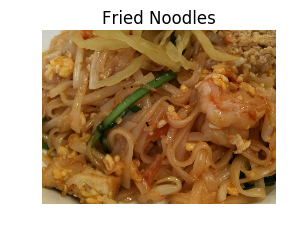

In [5]:
img = load_img('data/train/noodles_fried/4012787089_d1cca54838.jpg')
plt.figure(figsize = (3,3))
plt.imshow(img)
plt.axis('off')
plt.title('Fried Noodles')
plt.show()

In [6]:
x = img_to_array(img)
x2 = x.reshape((1,) + x.shape)

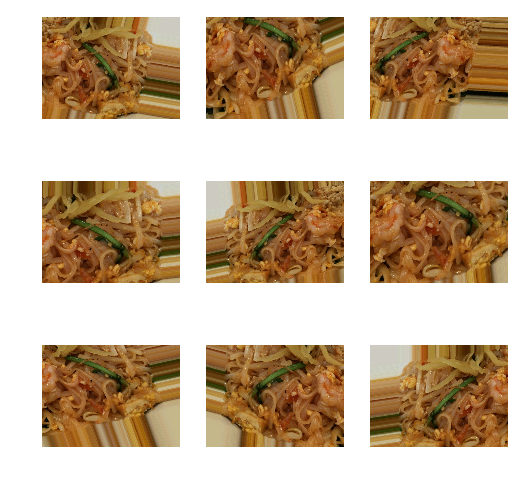

In [7]:
i = 0
fig = plt.figure(figsize = (6,6))
plt.title('Pre-processed')
for batch in datagen.flow(x2, batch_size = 1):
    i += 1
    if i > 9:
        break
    temp = batch.reshape(x.shape)
    plt.subplot(3, 3, i)
    plt.imshow(temp.astype('uint8'))
    plt.axis('off')
plt.show()

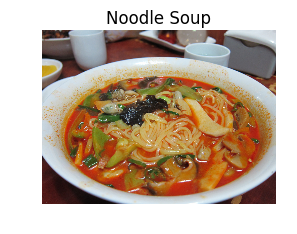

In [8]:
img = load_img('data/train/noodle_soup/5153183161_eb845fb8d9_b.jpg')
plt.figure(figsize = (3,3))
plt.imshow(img)
plt.axis('off')
plt.title('Noodle Soup')
plt.show()

In [9]:
# default settings
img_width, img_height = 299, 299

train_dir = 'data/train'
validate_dir = 'data/validate'
nb_epochs = 20
batch_size = 32
nb_classes = len(glob.glob(train_dir + '/*'))

In [10]:
# get number of images in training directory
nb_train_samples = 0
for r, dirs, files in os.walk(train_dir):
    for dr in dirs:
        nb_train_samples += len(glob.glob(os.path.join(r, dr + "/*")))
print(nb_train_samples)

251


In [11]:
# get number of images in validation directory
nb_validate_samples = 0
for r, dirs, files in os.walk(validate_dir):
    for dr in dirs:
        nb_validate_samples += len(glob.glob(os.path.join(r, dr + "/*")))
print(nb_validate_samples)

71


In [12]:
# data pre-processing for training
train_datagen =  ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    fill_mode = 'nearest',
    horizontal_flip = True)

In [13]:
# data pre-processing for validation
validate_datagen =  ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    fill_mode = 'nearest',
    horizontal_flip = True)

In [14]:
# generate and store training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size)

Found 251 images belonging to 2 classes.


In [15]:
# generate and store validation data
validate_generator = validate_datagen.flow_from_directory(
    validate_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size)

Found 71 images belonging to 2 classes.


In [16]:
# set up transfer learning on pre-trained ImageNet Inception_V3 model - remove fully connected layer and replace
# with softmax for classifying 10 classes
incepV3_model = InceptionV3(weights = 'imagenet', include_top = False)
x = incepV3_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(nb_classes, activation = 'softmax')(x)
model = Model(input = incepV3_model.input, output = predictions)

A local file was found, but it seems to be incomplete or outdated.


In [17]:
# freeze all layers of the pre-trained model
for layer in incepV3_model.layers:
    layer.trainable = False

In [18]:
# compile the new model using a RMSProp optimizer
model.compile(optimizer = 'rmsprop',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'])

In [19]:
# fit the model, log the results and the training time
now = datetime.datetime.now
t = now()
transfer_learning_history = model.fit_generator(
    train_generator,
    nb_epoch = nb_epochs,
    samples_per_epoch = nb_train_samples,
    validation_data = validate_generator,
    nb_val_samples = nb_validate_samples,
    class_weight='auto')
print('Training time: %s' % (now() - t))

Epoch 1/20
251/251 [==============================] - 128s - loss: 0.5392 - acc: 0.8287 - val_loss: 0.5194 - val_acc: 0.8592
Epoch 2/20
251/251 [==============================] - 123s - loss: 0.1570 - acc: 0.9442 - val_loss: 0.3736 - val_acc: 0.9014
Epoch 3/20
251/251 [==============================] - 122s - loss: 0.1163 - acc: 0.9402 - val_loss: 0.8830 - val_acc: 0.7887
Epoch 4/20
251/251 [==============================] - 123s - loss: 0.1169 - acc: 0.9562 - val_loss: 0.4483 - val_acc: 0.9014
Epoch 5/20
251/251 [==============================] - 123s - loss: 0.1031 - acc: 0.9721 - val_loss: 1.2057 - val_acc: 0.7606
Epoch 6/20
251/251 [==============================] - 122s - loss: 0.1543 - acc: 0.9522 - val_loss: 0.4751 - val_acc: 0.8873
Epoch 7/20
251/251 [==============================] - 122s - loss: 0.1013 - acc: 0.9721 - val_loss: 0.6568 - val_acc: 0.8310
Epoch 8/20
251/251 [==============================] - 122s - loss: 0.1130 - acc: 0.9482 - val_loss: 0.3488 - val_acc: 0.9296


In [20]:
# evaluate the performance the new model and report the results
score = model.evaluate_generator(validate_generator, nb_validate_samples/batch_size)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 2.03834962845
Test Accuracy: 0.857142865658


In [21]:
# save transfer learning model for offline prediction purposes
model.save('noodles_inception_v3_model_tl.h5')

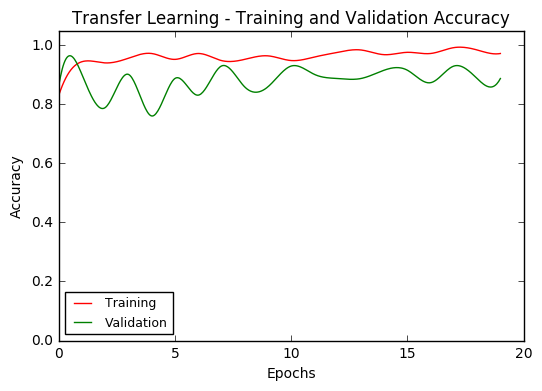

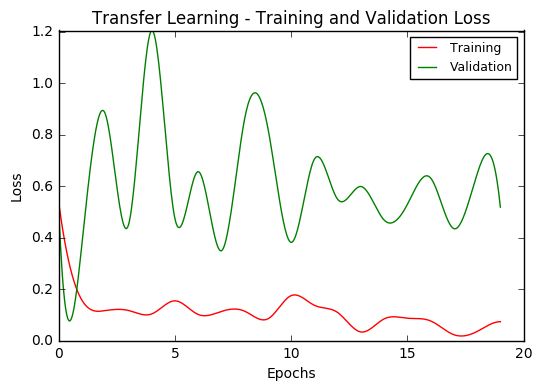

In [22]:
xfer_acc = transfer_learning_history.history['acc']
val_acc = transfer_learning_history.history['val_acc']
xfer_loss = transfer_learning_history.history['loss']
val_loss = transfer_learning_history.history['val_loss']
epochs = range(len(xfer_acc))

x = np.array(epochs)
y = np.array(xfer_acc)
x_smooth = np.linspace(x.min(), x.max(), 500)
y_smooth = spline(x, y, x_smooth)
plt.plot(x_smooth, y_smooth, 'r-', label = 'Training')

x1 = np.array(epochs)
y1 = np.array(val_acc)
x1_smooth = np.linspace(x1.min(), x1.max(), 500)
y1_smooth = spline(x1, y1, x1_smooth)

plt.plot(x1_smooth, y1_smooth, 'g-', label = 'Validation')
plt.title('Transfer Learning - Training and Validation Accuracy')
plt.legend(loc = 'lower left', fontsize = 9)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0,1.05)

plt.figure()
x = np.array(epochs)
y = np.array(xfer_loss)
x_smooth = np.linspace(x.min(), x.max(), 500)
y_smooth = spline(x, y, x_smooth)
plt.plot(x_smooth, y_smooth, 'r-', label = 'Training')

x1 = np.array(epochs)
y1 = np.array(val_loss)
x1_smooth = np.linspace(x1.min(), x1.max(), 500)
y1_smooth = spline(x1, y1, x1_smooth)

plt.plot(x1_smooth, y1_smooth, 'g-', label = 'Validation')
plt.title('Transfer Learning - Training and Validation Loss')
plt.legend(loc = 'upper right', fontsize = 9)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0,max(y1))
plt.show()

In [23]:
validate_generator.total_batches_seen

262

In [24]:
predict_files = glob.glob("noodles_test/*.jpg")

In [25]:
im = cv2.imread(predict_files[0])
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
im = cv2.resize(im, (256, 256)).astype(np.float32)
im = np.expand_dims(im, axis = 0)/255

In [26]:
predictor, image_id = [], []
for i in predict_files:
    im = cv2.imread(i)
    im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (256, 256)).astype(np.float32) / 255.0
    im = np.expand_dims(im, axis =0)
    outcome = [np.argmax(model.predict(im))]
    predictor.extend(list(outcome))
    image_id.extend([i.rsplit("\\")[-1]])

In [27]:
final = pd.DataFrame()
final["id"] = image_id
final["Noodles"] = predictor
final.head(29)

,id,Noodles
0,noodles_fried_1362891196_7d75cf20f2_b.jpg,0
1,noodles_fried_14184195178_547c97c26f.jpg,1
2,noodles_fried_16396588549_e6c8e4d8f4_b.jpg,0
3,noodles_fried_17039137251_62c9fc6fa7_b.jpg,0
4,noodles_fried_20756744642_88b25bfe65_b.jpg,1
5,noodles_fried_3124561235_f2364895d8_b.jpg,1
6,noodles_fried_3375141488_8da8f7a1ae.jpg,1
7,noodles_fried_3675581924_7c531552ec_b.jpg,1
8,noodles_fried_3845786256_c7a572d603_b.jpg,1
9,noodles_fried_4042684214_8060899bfc_b.jpg,1


In [28]:
classes = train_generator.class_indices
classes = {value : key for key, value in classes.items()}

In [29]:
final["Noodles"] = final["Noodles"].apply(lambda x: classes[x])
final.head(29)

,id,Noodles
0,noodles_fried_1362891196_7d75cf20f2_b.jpg,noodle_soup
1,noodles_fried_14184195178_547c97c26f.jpg,noodles_fried
2,noodles_fried_16396588549_e6c8e4d8f4_b.jpg,noodle_soup
3,noodles_fried_17039137251_62c9fc6fa7_b.jpg,noodle_soup
4,noodles_fried_20756744642_88b25bfe65_b.jpg,noodles_fried
5,noodles_fried_3124561235_f2364895d8_b.jpg,noodles_fried
6,noodles_fried_3375141488_8da8f7a1ae.jpg,noodles_fried
7,noodles_fried_3675581924_7c531552ec_b.jpg,noodles_fried
8,noodles_fried_3845786256_c7a572d603_b.jpg,noodles_fried
9,noodles_fried_4042684214_8060899bfc_b.jpg,noodles_fried


In [30]:
for i, layer in enumerate(model.layers):
   print(i, layer.name)

0 input_1
1 convolution2d_1
2 batchnormalization_1
3 convolution2d_2
4 batchnormalization_2
5 convolution2d_3
6 batchnormalization_3
7 maxpooling2d_1
8 convolution2d_4
9 batchnormalization_4
10 convolution2d_5
11 batchnormalization_5
12 maxpooling2d_2
13 convolution2d_9
14 batchnormalization_9
15 convolution2d_7
16 convolution2d_10
17 batchnormalization_7
18 batchnormalization_10
19 averagepooling2d_1
20 convolution2d_6
21 convolution2d_8
22 convolution2d_11
23 convolution2d_12
24 batchnormalization_6
25 batchnormalization_8
26 batchnormalization_11
27 batchnormalization_12
28 mixed0
29 convolution2d_16
30 batchnormalization_16
31 convolution2d_14
32 convolution2d_17
33 batchnormalization_14
34 batchnormalization_17
35 averagepooling2d_2
36 convolution2d_13
37 convolution2d_15
38 convolution2d_18
39 convolution2d_19
40 batchnormalization_13
41 batchnormalization_15
42 batchnormalization_18
43 batchnormalization_19
44 mixed1
45 convolution2d_23
46 batchnormalization_23
47 convolution2d_

In [31]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, None, None, 32 896         input_1[0][0]                    
____________________________________________________________________________________________________
batchnormalization_1 (BatchNorma (None, None, None, 32 128         convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, None, None, 32 9248        batchnormalization_1[0][0]       
___________________________________________________________________________________________

In [32]:
# Step 1 - Set up fine tuning on pre-trained ImageNet Inception_V3 model - freeze lower 94 layers only
for layer in model.layers[:94]:
    layer.trainable = False
for layer in model.layers[94:]:
    layer.trainable = True
    
# Step 2 - Compile the revised model using SGD optimizer with a learing rate of 0.0001 and a momentum of 0.9
model.compile(optimizer = SGD(lr = 0.0001, momentum=0.9), 
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'])

# Step 3 - Fit the revised model, log the results and the training time
now = datetime.datetime.now
t = now()
fine_tuning_history = model.fit_generator(
    train_generator,
    nb_epoch = nb_epochs,
    samples_per_epoch = nb_train_samples,
    validation_data = validate_generator,
    nb_val_samples = nb_validate_samples,
    class_weight='auto')
print('Training time: %s' % (now() - t))

Epoch 1/20
251/251 [==============================] - 189s - loss: 0.0644 - acc: 0.9801 - val_loss: 0.4964 - val_acc: 0.9014
Epoch 2/20
251/251 [==============================] - 177s - loss: 0.0689 - acc: 0.9761 - val_loss: 0.8240 - val_acc: 0.8732
Epoch 3/20
251/251 [==============================] - 179s - loss: 0.0381 - acc: 0.9801 - val_loss: 0.5255 - val_acc: 0.8592
Epoch 4/20
251/251 [==============================] - 182s - loss: 0.0286 - acc: 0.9920 - val_loss: 0.5014 - val_acc: 0.8873
Epoch 5/20
251/251 [==============================] - 182s - loss: 0.0248 - acc: 0.9920 - val_loss: 0.8218 - val_acc: 0.8732
Epoch 6/20
251/251 [==============================] - 183s - loss: 0.0979 - acc: 0.9721 - val_loss: 0.6294 - val_acc: 0.8732
Epoch 7/20
251/251 [==============================] - 183s - loss: 0.0368 - acc: 0.9920 - val_loss: 0.6955 - val_acc: 0.8592
Epoch 8/20
251/251 [==============================] - 181s - loss: 0.0410 - acc: 0.9920 - val_loss: 0.6043 - val_acc: 0.8873


In [33]:
# evaluate the performance the new model and report the results
score = model.evaluate_generator(validate_generator, nb_validate_samples/batch_size)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.710605144501
Test Accuracy: 0.90625


In [34]:
# save fine-tuning model for offline prediction purposes
model.save('noodles_inception_v3_model_ft.h5')

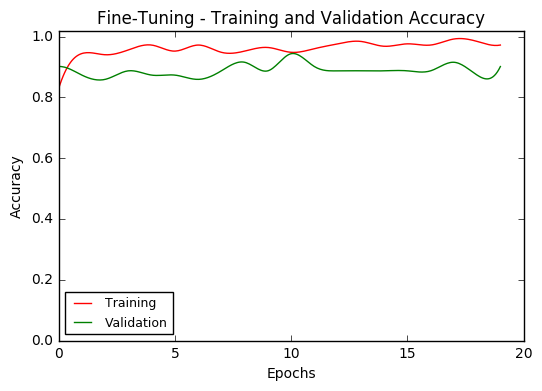

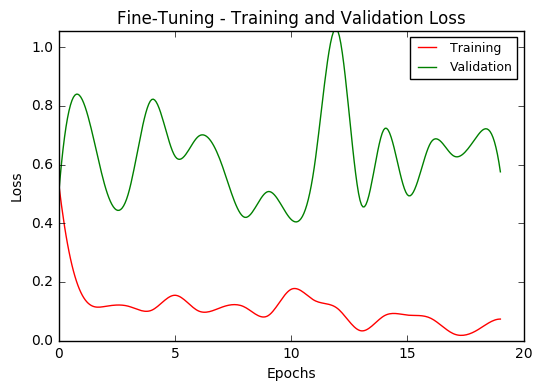

In [35]:
ft_acc = fine_tuning_history.history['acc']
val_acc = fine_tuning_history.history['val_acc']
ft_loss = fine_tuning_history.history['loss']
val_loss = fine_tuning_history.history['val_loss']
epochs = range(len(ft_acc))

x = np.array(epochs)
y = np.array(xfer_acc)
x_smooth = np.linspace(x.min(), x.max(), 300)
y_smooth = spline(x, y, x_smooth)
plt.plot(x_smooth, y_smooth, 'r-', label = 'Training')

x1 = np.array(epochs)
y1 = np.array(val_acc)
x1_smooth = np.linspace(x1.min(), x1.max(), 300)
y1_smooth = spline(x1, y1, x1_smooth)

plt.plot(x1_smooth, y1_smooth, 'g-', label = 'Validation')
plt.title('Fine-Tuning - Training and Validation Accuracy')
plt.legend(loc = 'lower left', fontsize = 9)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0,1.02)

plt.figure()
x = np.array(epochs)
y = np.array(xfer_loss)
x_smooth = np.linspace(x.min(), x.max(), 300)
y_smooth = spline(x, y, x_smooth)
plt.plot(x_smooth, y_smooth, 'r-', label = 'Training')

x1 = np.array(epochs)
y1 = np.array(val_loss)
x1_smooth = np.linspace(x1.min(), x1.max(), 300)
y1_smooth = spline(x1, y1, x1_smooth)

plt.plot(x1_smooth, y1_smooth, 'g-', label = 'Validation')
plt.title('Fine-Tuning - Training and Validation Loss')
plt.legend(loc = 'upper right', fontsize = 9)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0,max(y1))
plt.show()

In [36]:
validate_generator.total_batches_seen

530

In [37]:
# predict unseen images
predict_files = glob.glob("noodles_test/*.jpg")

In [38]:
im = cv2.imread(predict_files[0])
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
im = cv2.resize(im, (256, 256)).astype(np.float32)
im = np.expand_dims(im, axis = 0)/255

In [39]:
predictor, image_id = [], []
for i in predict_files:
    im = cv2.imread(i)
    im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (256, 256)).astype(np.float32) / 255.0
    im = np.expand_dims(im, axis =0)
    outcome = [np.argmax(model.predict(im))]
    predictor.extend(list(outcome))
    image_id.extend([i.rsplit("\\")[-1]])

In [40]:
final = pd.DataFrame()
final["id"] = image_id
final["Noodles"] = predictor 
final.head(29)

,id,Noodles
0,noodles_fried_1362891196_7d75cf20f2_b.jpg,0
1,noodles_fried_14184195178_547c97c26f.jpg,1
2,noodles_fried_16396588549_e6c8e4d8f4_b.jpg,0
3,noodles_fried_17039137251_62c9fc6fa7_b.jpg,0
4,noodles_fried_20756744642_88b25bfe65_b.jpg,1
5,noodles_fried_3124561235_f2364895d8_b.jpg,1
6,noodles_fried_3375141488_8da8f7a1ae.jpg,1
7,noodles_fried_3675581924_7c531552ec_b.jpg,1
8,noodles_fried_3845786256_c7a572d603_b.jpg,1
9,noodles_fried_4042684214_8060899bfc_b.jpg,1


In [41]:
classes = train_generator.class_indices
classes = {value : key for key, value in classes.items()}

In [42]:
final["Noodles"] = final["Noodles"].apply(lambda x: classes[x])
final.head(29)

,id,Noodles
0,noodles_fried_1362891196_7d75cf20f2_b.jpg,noodle_soup
1,noodles_fried_14184195178_547c97c26f.jpg,noodles_fried
2,noodles_fried_16396588549_e6c8e4d8f4_b.jpg,noodle_soup
3,noodles_fried_17039137251_62c9fc6fa7_b.jpg,noodle_soup
4,noodles_fried_20756744642_88b25bfe65_b.jpg,noodles_fried
5,noodles_fried_3124561235_f2364895d8_b.jpg,noodles_fried
6,noodles_fried_3375141488_8da8f7a1ae.jpg,noodles_fried
7,noodles_fried_3675581924_7c531552ec_b.jpg,noodles_fried
8,noodles_fried_3845786256_c7a572d603_b.jpg,noodles_fried
9,noodles_fried_4042684214_8060899bfc_b.jpg,noodles_fried


In [43]:
final.to_csv("csv/noodles_with_pretrained_inception_v3_model_ft_test.csv", index = False)